<p align="center">
  <a href="https://colab.research.google.com/drive/1XgAZRUC6rZWay8_m_m0P79iscu2lKXl_?authuser=0#scrollTo=B-KylB8OVkbs">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
  </a>
</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !pip install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-hc_zdpx2
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-hc_zdpx2
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit d61f6fecd4285d148b7ad34ab8d4b909844cbc30
  Running command git submodule update --init --recursive -q
  Encountered 22 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebooks/course_UvA-DL/07-deep-energy-based-generative-models.ipynb
        .notebooks/course_UvA-DL/08-

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # functional for activation function
from torch.optim import Adam
import lightning as L
from torch.utils.data import TensorDataset , DataLoader

@ source statquest
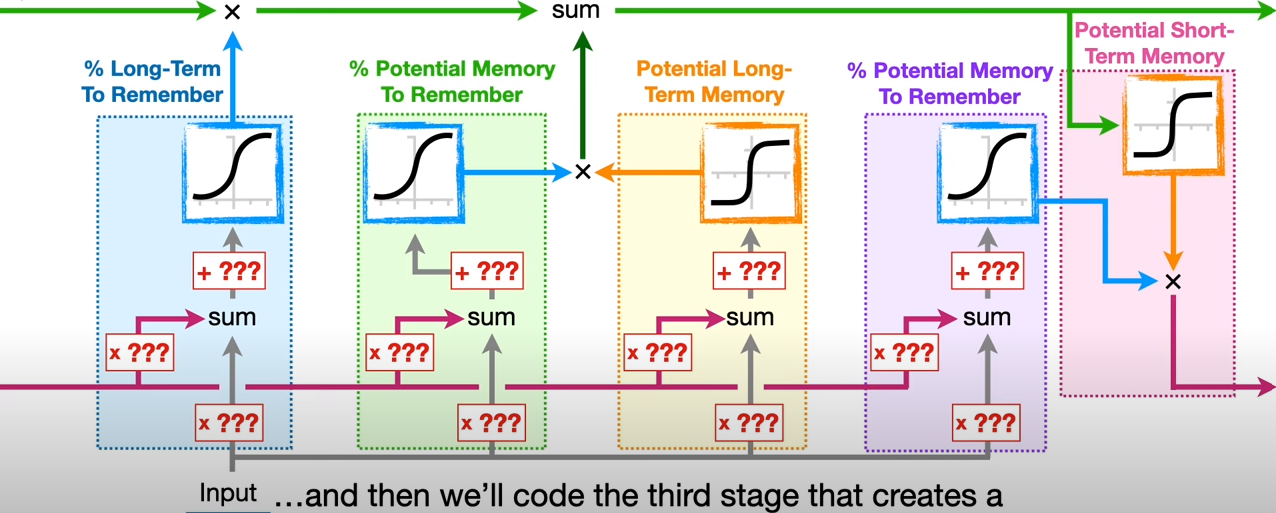

    super().__init__()  

  * super() function to call the methods of superclass in the subclass
  * __init__() is constructor method. It is called when an object is created from the class and allows the class to initialize the attributes of the class.
  * super().__init__() : Call the constructor of the parent class (L.LightningModule) so that it can do initialization work first .

In [ ]:
class LSTMbyHand(L.LightningModule): # inherit attributes and methods from the parent class
  def __init__(self):
    """
    Create and initialize the Weights and Bias tensors
    """

    super().__init__()  # initialization code of its parent class, L.LightningModule

    mean = torch.tensor(0.0)
    std = torch.tensor(1.0)

    self.wlr1 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True ) # requires_grad True as we need to optimize .
    self.wlr2 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True )
    self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad = True )

    self.wpr1 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True )
    self.wpr2 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True )
    self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad = True )

    self.wp1 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True )
    self.wp2 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True )
    self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad = True )

    self.wo1 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True )
    self.wo2 = nn.Parameter(torch.normal(mean  = mean , std = std), requires_grad = True )
    self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad = True )

  def lstm_unit(self, input_value, long_memory, short_memory):
    """
    Do the LSTM math
    """
    long_remenber_percent = torch.sigmoid((short_memory* self.wlr1) + ( input_value * self.wlr2) + self.blr1)       # forget gate (f_t)
    potential_remember_percent= torch.sigmoid((short_memory* self.wpr1) + ( input_value * self.wpr2) + self.bpr1)   # Input gate  (i_t)
    potential_memory = torch.tanh((short_memory * self.wp1) + (input_value * self.wp2) + self.bp1)                  # update state (g_t)
    updated_long_memory = ((long_remenber_percent * long_memory) + (potential_remember_percent * potential_memory)) # memory state : c_t = f_t * c_{t-1} + i_t * g_t
    output_percent = torch.sigmoid((short_memory * self.wo1) + (input_value * self.wo2) + self.bo1)                 # output gate  (o_t)
    updated_short_memory = output_percent * torch.tanh(updated_long_memory)                                         # o_t * tanh(c_t)

    return ([updated_long_memory , updated_short_memory])


  def forward(self, input ):    # input is an array that cintains the first 4 days of stock market values from either Company A or Company B
    """
    Make a forward pass through unrolled LSTM
    """
    long_memory = 0
    short_memory = 0
    day1 = input[0]
    day2 = input[1]
    day3 = input[2]
    day4 = input[3]

    long_memory , short_memory = self.lstm_unit(day1, long_memory, short_memory)

    long_memory , short_memory = self.lstm_unit(day2, long_memory, short_memory)

    long_memory , short_memory = self.lstm_unit(day3, long_memory, short_memory)

    long_memory , short_memory = self.lstm_unit(day4, long_memory, short_memory)

    return short_memory




  def configure_optimizers(self):
    '''
    Configure Adam Optimizer
    '''

    return Adam(self.parameters())

  def training_step(self, batch, batch_idx):
    """
    Calculate log and loss in the traing step
    """

    input_i , label_i = batch
    output_i = self.forward(input_i[0])
    loss = (output_i - label_i)**2

    self.log('train_loss', loss)      # it will create a new file in a directory called lightning_logs and store whatever we want to keep track of in it

    if (label_i == 0):                # make prediction for Company A and B ( 2 different )
      self.log('out_0', output_i)

    else:
      self.log('out_1', output_i)

    return loss






Lstm_unit

   * long_remember_percent

   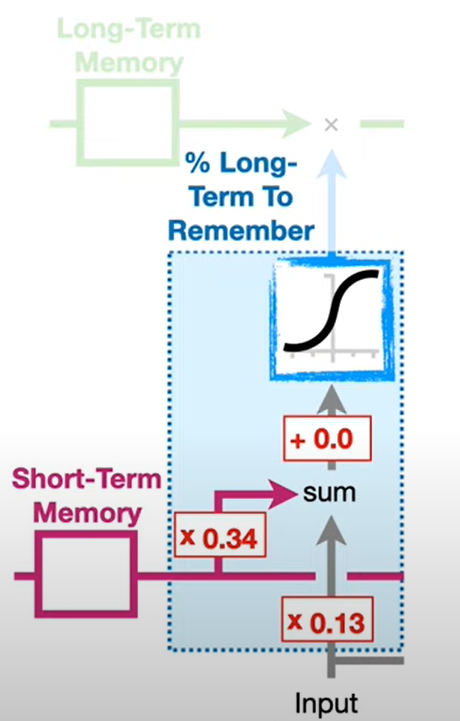


   * 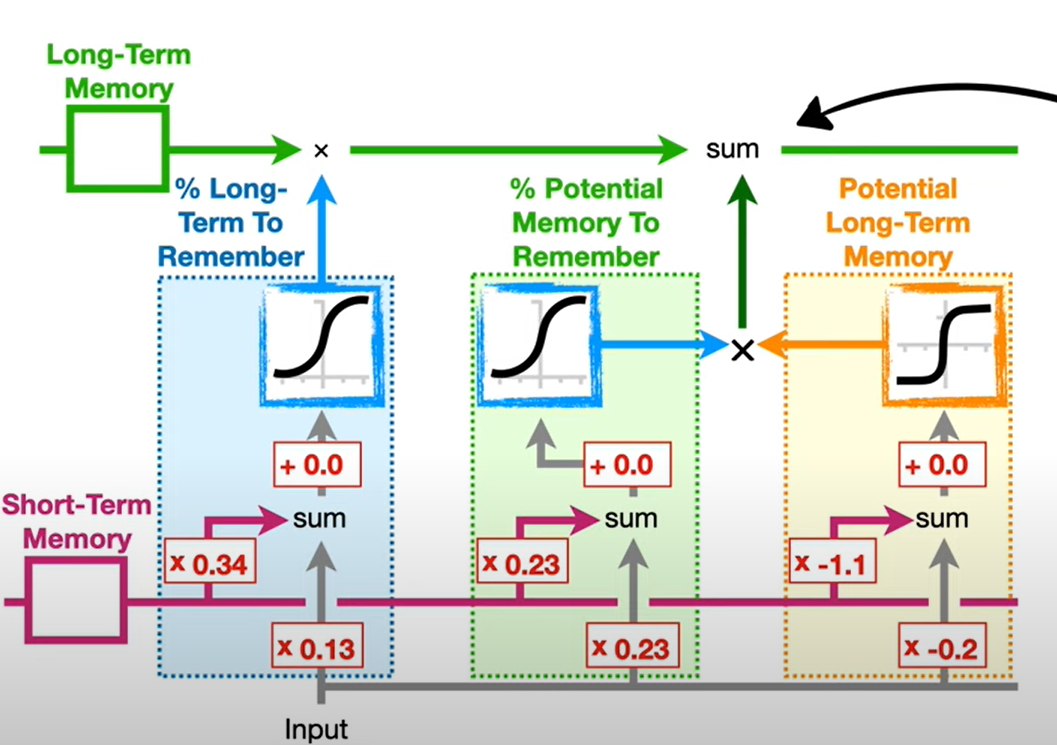

In [ ]:
model = LSTMbyHand()

print("\nNow let's compare the observed and predicted values ...")
print('Company A: observed = 0, predicted=', model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print('Company B: observed = 1, predicted=', model(torch.tensor([1., 0.5, 0.25, 1.])).detach())



Now let's compare the observed and predicted values ...
Company A: observed = 0, predicted= tensor(0.1702)
Company B: observed = 1, predicted= tensor(0.1813)


For Company B it's result is horrible

In [ ]:
#Train
inputs = torch.tensor([[0., 0.5, 0.25, 1.], [1., 0.5, 0.25, 1.]])
labels = torch.tensor([0., 1.])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)


In [ ]:
trainer = L.Trainer(max_epochs = 2000)
trainer.fit(model, train_dataloaders = dataloader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 12    
--------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 12    
--------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
/usr/local/lib/python3.10/di

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2000` reached.


In [ ]:
#Prediction
print("\nNow let's compare the observed and predicted values ...")
print('Company A: observed = 0, predicted=', model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print('Company B: observed = 1, predicted=', model(torch.tensor([1., 0.5, 0.25, 1.])).detach())



Now let's compare the observed and predicted values ...
Company A: observed = 0, predicted= tensor(0.0015)
Company B: observed = 1, predicted= tensor(0.8977)


Now the prediction is better than the previous one .
 * In terminal : we can see tensorboard by : tensorboard --logdir=lightning_logs/

Now from the tensorboard if we see that that loss curve is not flat , so we need  to perform more traing steps.

## Now if we want to add aditional training epoch .

In [ ]:
path_to_best_checkpoint = trainer.checkpoint_callback.best_model_path

trainer = L.Trainer(max_epochs = 3000)
trainer.fit(model, train_dataloaders = dataloader , ckpt_path = path_to_best_checkpoint) # set ckpt_path tot the last chcekpoint



INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=1999-step=4000.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=1999-step=4000.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:360: The dirpath has changed from '/content/lightning_logs/version_0/checkpoints' to '/content/lightning_logs/version_1/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Onl

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3000` reached.


In [ ]:
#Prediction
print("\nNow let's compare the observed and predicted values ...")
print('Company A: observed = 0, predicted=', model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print('Company B: observed = 1, predicted=', model(torch.tensor([1., 0.5, 0.25, 1.])).detach())


Now let's compare the observed and predicted values ...
Company A: observed = 0, predicted= tensor(0.0002)
Company B: observed = 1, predicted= tensor(0.9506)


More improvement .

In [ ]:
#Without scratch
